<h1>Scientific coding bootcamp notebook 5: QuantumOptics.jl</h1>

QuantumOptics.jl is a state of the art package for simulating quantum systems.  The point of this notebook is just to give an opinionated introduction to the package.  The package is well documented, and you do just about as well to just go through their examples (some of which I've reused). 

Simulating quantum systems will nicely combine all of the previous topics: Linear algebra, differential equations, and Fourier analysis. 

In [1]:
using Plots, QuantumOptics

<h3>Particle in a quadratic potential.</h3>

This is not the conceptually simplest example, but we start with it because it is easy to appreciate the result.  It simulates the motion of a quantum particle in a quadratic potential (i.e. a quantum harmonic oscillator). 

This example is based on that of https://docs.qojulia.org/examples/particle-in-harmonic-trap/

In [16]:
# Step 1: Define bases for the Hilbert space.
xmin = -5
xmax = 5
N = 128
b_position = PositionBasis(xmin, xmax, N)
b_momentum = MomentumBasis(b_position)

Momentum(pmin=-40.21238596594935, pmax=40.21238596594935, N=128)

In [28]:
# Step 2A: Define relevant operators.
T_px = transform(b_momentum, b_position)    # Change of basis operator
T_xp = dagger(T_px)                         # Change of basis operator
x = position(b_position)                    # Position operator
p = momentum(b_momentum)                    # Momentum operator

# Step 2B: Define Hamiltonian.
m = 1.                                      # Particle mass
ω = 0.5                                     # Strength of trapping potential
H_kin = LazyProduct(T_xp, p^2/2m, T_px)     # Just the p^2 part of the Hamiltonian
V = ω*x^2
H = LazySum(H_kin, V)                       # Full Hamiltonian

LazySum(dim=128x128)
  basis: Position(xmin=-5, xmax=5, N=128)
  operators: 2

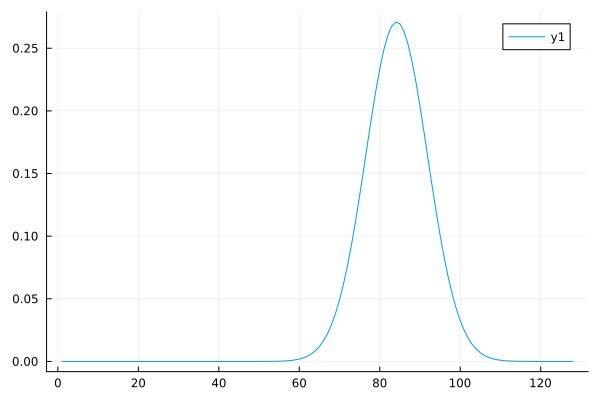

In [21]:
# Step 3: Initial conditions and solution time steps.
x0 = 1.5
p0 = 0
sigma0 = 0.6
Ψ0 = gaussianstate(b_position, x0, p0, sigma0);  # Initial spatial wavefunction
T = [0:0.1:2pi;]                                 # Time steps to solve at
plot(abs.(Ψ0.data))                              # Initial condition spatial wavefunction probability density 

In [22]:
# Step 4: Solve the Schrodinger equation. 
tout, Ψt = timeevolution.schroedinger(T, Ψ0, H);

[ Info: Saved animation to C:\Users\anonc\Desktop\ScientificCodingBootcamp\SHOAnim.gif


Plots.AnimatedGif("C:\\Users\\anonc\\Desktop\\ScientificCodingBootcamp\\SHOAnim.gif")
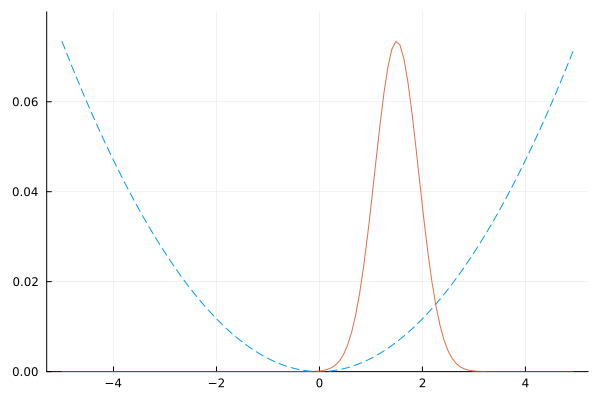

In [23]:
# Step 5: Visualize solution.
x_points = samplepoints(b_position)
V_scaled = x_points.^2 * (maximum(abs.(Ψ0.data).^2)/maximum(x_points.^2))
function QHOPlot(psi)
    plot(x_points,V_scaled; ylim=(0.0,0.08),linestyle=:dash,legend=false)
    plot!(x_points,abs.(psi.data).^2)
end
anim = @animate for i=1:length(T)
    Ψ = Ψt[i]
    QHOPlot(Ψ)
end
gif(anim,"SHOAnim.gif",fps=10)

<h3>Raman transition in quantum 3-level system.</h3>

This example considers a transition in an atom with 3 internal levels.  

Attribution: This example is based on that of https://docs.qojulia.org/examples/raman/

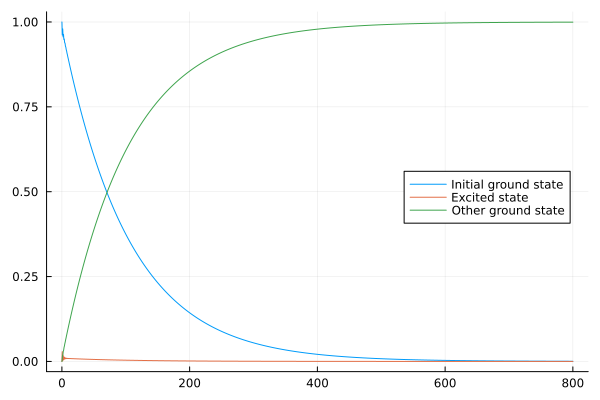

In [24]:
# System parameters.
γ₃ = 1.
Ω = .5γ₃
Δ₂ = 5γ₃
Δ₃ = 0.0

# Step 1: Define Hilbert space basis.
b = NLevelBasis(3)

# Step 2A: Define useful operators.
σ₁ = transition(b, 1, 2)
σ₃ = transition(b, 3, 2)
proj₂ = transition(b, 2, 2)
proj₃ = σ₃*dagger(σ₃)

# Step 2B: Define Hamiltonian and jump operators.
H = Δ₂*proj₂ + Δ₃*proj₃ + Ω*(σ₁ + dagger(σ₁))
J = [sqrt(γ₃)*σ₃];

# Step 3: Initial conditions and solution time steps.
ψ₀ = nlevelstate(b, 1)
tmax = 800/γ₃
dt = 0.1
tlist = [0:dt:tmax;]

# Step 4: Solve time evolution.
tout, ρt = timeevolution.master(tlist, ψ₀, H, J)

# Step 5: Compute level statistics and visualize solution.
p1 = [real(expect(σ₁*dagger(σ₁), ρt[t])) for t in 1:length(tout)]
p2 = [real(expect(proj₂, ρt[t])) for t in 1:length(tout)]
p3 = [real(expect(proj₃, ρt[t])) for t in 1:length(tout)]
plot(tout, [p1,p2,p3], labels = ["Initial ground state" "Excited state" "Other ground state"], legend=:right)

As the examples show, there are several steps to setting up a simulation with QuantumOptics: 
1. You define your Hilbert space bases.
2. Define whatever operators you need, culminating with defining the Hamiltonian.
3. Define an initial state and times at which you want a solution.
4. Pass the Hamiltonian and initial state to a solver.
5. Process the solution, maybe plotting the result.

The steps above are part of pretty much any simulation you do, but sometimes extra work is needed.  E.g. for systems with dissipation, you must define "jump operators" in addition to the Hamiltonian.  There are also many options for each step.  There are frequently different bases that can be used in step 1, different ways to define the Hamiltonian in step 3, and different solver options in step 4.  Knowing which options to use when is mainly something you acquire through experience.  We will walk through the steps and explain some of the common variations.  

<h2>Bases</h2>

The first step is always to define the basis for your Hilbert space.  This serves three purposes: 
1. Firstly, QuantumOptics provides special operators tailored to each basis.  For example, the `FockBasis`, which represents a photon mode, has operators for adding or removing a single photon (`create` and `destroy`).
2. Secondly, QuantumOptics provides powerful tools for describing complex systems by combining bases.  For instance, an atom might have a `PositionBasis` to describe it's spatial wavefunction and a `SpinBasis` to describe its internal state.  You can form a basis and corresponding operators for the entire atom Hilbert space using the `tensor` function or equivalent `⊗` infix.
3. Lastly, keeping track of bases provides an important consistency check for your code.  It's hard to overstate how helpful this is.

Here are some examples of useful bases. 

In [26]:
#= PositionBasis and MomentumBasis.  Since the same Hilbert space has both 
a position basis and momentum basis, you can also construct one from the other. 
=#

xmin = -5
xmax = 5
N = 128
bPos1 = PositionBasis(xmin, xmax, N)
bMom1 = MomentumBasis(bPos1)

pmin = -5
pmax = 5
N = 128
bMom2 = MomentumBasis(pmin,pmax,N)
bPos2 = PositionBasis(bMom2)

# SpinBasis
bSpinHalf = SpinBasis(1//2)
bSpinTwo = SpinBasis(2)

# NLevelBasis
N = 4
b4Level = NLevelBasis(N)

# FockBasis
N = 10
bFock = FockBasis(N)

# Composite bases
bSpinHalfPosition = bPos1 ⊗ bSpinHalf

[Position(xmin=-5, xmax=5, N=128) ⊗ Spin(1/2)]

<h3>Operators</h3>

Each basis type comes with some built-in handy operators.  Each operator has a `data` field which contains a matrix representing the state with respect to its basis.  Here are some examples. 

In [33]:
# PositionBasis and MomentumBasis
x1 = position(bPos1)
p1 = momentum(bPos1)
T_px = transform(bMom1, bPos1)    # Change of basis operator

# SpinBasis
σx = sigmax(bSpinHalf)
σz = sigmaz(bSpinHalf)

#NLevelBasis
Ω12 = transition(b, 1, 2)

# FockBasis
at = create(bFock)
a = destroy(bFock)
n = number(bFock)

# Composite operators
spinPotential = 1/2 * x1^2 ⊗ σz

Operator(dim=256x256)
  basis: [Position(xmin=-5, xmax=5, N=128) ⊗ Spin(1/2)]sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  247, 248, 249, 250, 251, 252, 253, 254, 255, 256], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  247, 248, 249, 250, 251, 252, 253, 254, 255, 256], ComplexF64[12.5 + 0.0im, 12.1124267578125 + 0.0im, 11.73095703125 + 0.0im, 11.3555908203125 + 0.0im, 10.986328125 + 0.0im, 10.6231689453125 + 0.0im, 10.26611328125 + 0.0im, 9.9151611328125 + 0.0im, 9.5703125 + 0.0im, 9.2315673828125 + 0.0im  …  -8.89892578125 + 0.0im, -9.2315673828125 + 0.0im, -9.5703125 + 0.0im, -9.9151611328125 + 0.0im, -10.26611328125 + 0.0im, -10.6231689453125 + 0.0im, -10.986328125 + 0.0im, -11.3555908203125 + 0.0im, -11.73095703125 + 0.0im, -12.1124267578125 + 0.0im], 256, 256)

<h3>States</h3>

A state is a vector in your Hilbert space.  As with operators, there are convenience functions for making states in each standard basis.  Each state has a `data` field which contains an underlying vector or matrix representing the state with respect to its basis. 

In [36]:
# PositionBasis and MomentumBasis
x0 = 1.5
p0 = 0
sigma0 = 0.6
ψPos = gaussianstate(bPos1,x0,p0,sigma0)       # Gaussian wavefunction

# SpinBasis
ψSpin = spinup(bSpinHalf)                      # Spin up state

#NLevelBasis
ψ4Level = nlevelstate(b4Level,2)               # State in the second level

# FockBasis
ψFock = fockstate(bFock,3)                     # State with 3 photons

Ket(dim=11)
  basis: Fock(cutoff=10)
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

<h3>Time evolution</h3>

The actual solving of the quantum system is fairly easy--you just plug in the Hamiltonian and initial state to the relevant solver function, which is usually either `timeevolution.schroedinger` (for closed systems) or `timeevolution.master` (for open systems).  

In [37]:
# Toy example for a spin 1/2 system.
tspan = [0:0.05:5;]
ψ0 = spinup(bSpinHalf)
H = sigmax(bSpinHalf)
tout, ψt = timeevolution.schroedinger(tspan, ψ0, H);

# Master equation for the same system.
ρ0 = ψ0 ⊗ dagger(ψ0) 
κ = 1.
J = [sigmam(bSpinHalf)]
tout, ρt = timeevolution.master(tspan, ρ0, H, J; rates=[κ]);

In [39]:
ρt[1]

Operator(dim=2x2)
  basis: Spin(1/2)
 1.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im

<h3>Solution handling and plotting.</h3>

The solution object returned by the time evolution solver is a vector of state objects for each time step you requested.  You can access data by calling the `data` field of the states, but it's often more convenient to use the `expect` function to get expectation values of some operator with respect to the state. 

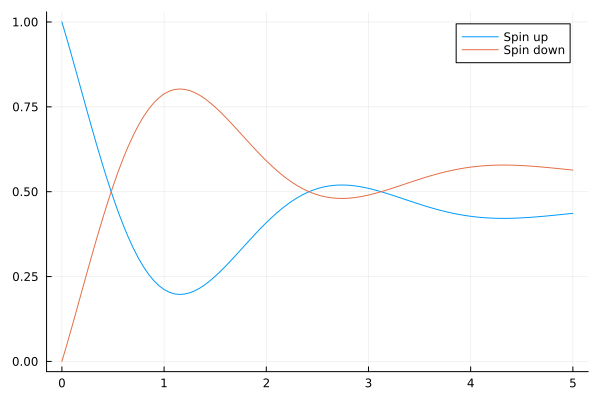

In [44]:
# Two different ways to access state data. 
sup = [real(expect(spinup(bSpinHalf) ⊗ dagger(spinup(bSpinHalf)), ρt[t])) for t in 1:length(tout)]
sdown = [abs.(ρ.data[2,2]) for ρ in ρt]

plot(tout, [sup,sdown]; labels = ["Spin up" "Spin down"])

<h2>Your turn.</h2>

Look at the examples on https://docs.qojulia.org/, find one of interest to you, and do it!